In [1]:
#Team : Yiming He; Taylor Albrecht Taylor Albrecht; Muhammad Zubair Arif; Rashon Barney; Muzamel Khan             
#Team: Big Brain
#Participating Team Members: Yiming He
import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy
import scipy.stats as stats

from rdd import rdd

# set the random seed:
np.random.seed(1234567)

# set sample size:
n = 100000

# set true parameters (betas and sd of u):
beta0 = 1
beta1 = 0.5
su = 2
d=0.5

# draw a sample of size n:
x = stats.norm.rvs(4, 1, size=n)
u = stats.norm.rvs(1, su, size=n)
threshold = 3.5
treatment = np.where(x >= threshold, 1, 0)
z= np.random.normal(0, 1, n)
y = d * treatment + beta0 + beta1 * x + u
data = pd.DataFrame({'y': y, 'x': x,'z':z})


# set up cutoff
data["x"] -= 3.5
rdd_df = data.assign(cutoff=(data["x"] > 0).astype(int))


def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)
plt.plot(data["x"], kernel(data["x"], c=0, h=1))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Weight by Age");

model = smf.wls("y~x*cutoff", rdd_df,weights=kernel(data["x"], c=0, h=1)).fit()

model.summary().tables[1]





/Users/hym0509/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:740: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.7811,0.016,233.614,0.000,3.749,3.813
x,0.5458,0.045,12.166,0.000,0.458,0.634
cutoff,0.4452,0.022,20.323,0.000,0.402,0.488
x:cutoff,0.0260,0.057,0.452,0.651,-0.087,0.139


Optimal bandwidth: 0.7530703259164199


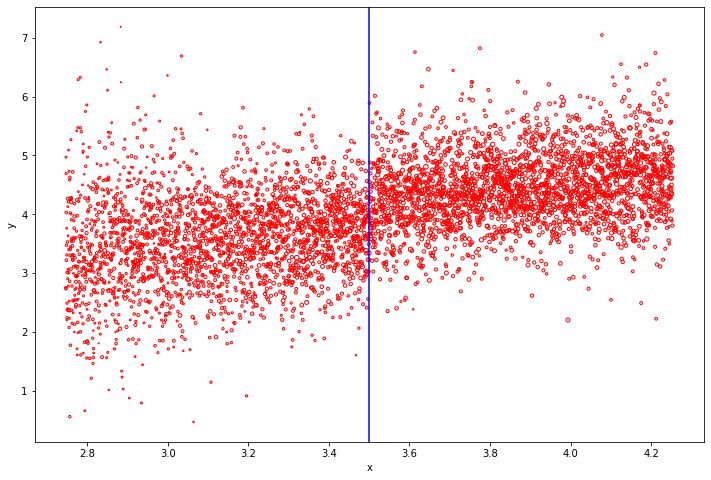

Estimation Equation:	 y ~ TREATED + x
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            WLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1170.
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:06:31   Log-Likelihood:            -1.0476e+05
No. Observations:               49467   AIC:                         2.095e+05
Df Residuals:                   49464   BIC:                         2.095e+05
Df Model:                           2                                         
Covariance Type:                  hc1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

/Users/hym0509/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


In [2]:
rdd without covariate
import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy
import scipy.stats as stats

from rdd import rdd

# set the random seed:
np.random.seed(1234567)

# set sample size:
n = 100000

# set true parameters (betas and sd of u):
beta0 = 1
beta1 = 0.5
su = 2
d=0.5

# draw a sample of size n:
x = stats.norm.rvs(4, 1, size=n)
u = stats.norm.rvs(1, su, size=n)
threshold = 3.5
treatment = np.where(x >= threshold, 1, 0)

y = d * treatment + beta0 + beta1 * x + u
data = pd.DataFrame({'y': y, 'x': x,'treatment':treatment})





# set up bandwidth:
bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)
data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=threshold)

# scatter


data_binned = rdd.bin_data(data_rdd, 'y', 'x', 5000)
plt.figure(figsize=(12, 8))
plt.scatter(data_binned['x'], data_binned['y'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='r')
plt.axvline(x=3.5, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()




# estimation
model = rdd.rdd(data_rdd, 'x', 'y', cut=threshold)
print(model.fit(cov_type='hc1').summary())


# placebo

model = rdd.rdd(data_rdd, 'x', 'y', cut=0.5)
print(model.fit(cov_type='hc1').summary())


Optimal bandwidth: 0.7530703259164199


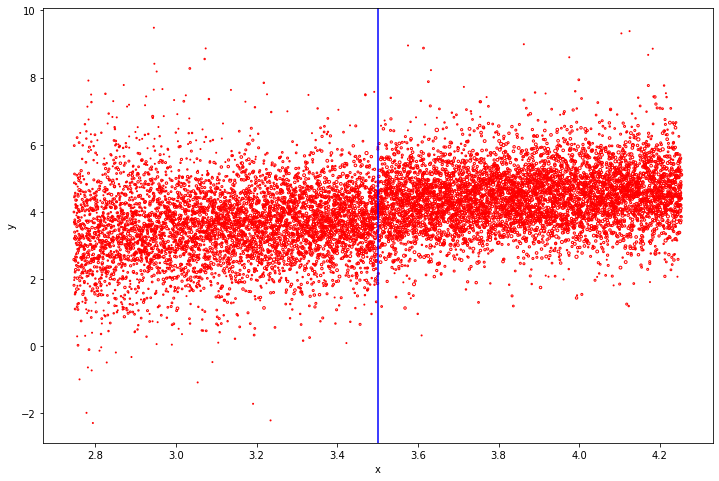

Estimation Equation:	 y ~ TREATED + x + z
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            WLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     780.0
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:12:52   Log-Likelihood:            -1.0476e+05
No. Observations:               49467   AIC:                         2.095e+05
Df Residuals:                   49463   BIC:                         2.096e+05
Df Model:                           3                                         
Covariance Type:                  hc1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept 

/Users/hym0509/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


In [4]:
#rdd with one covariate z

import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy
import scipy.stats as stats
import linearmodels.iv as iv
from rdd import rdd

# set the random seed:
np.random.seed(1234567)

# set sample size:
n = 100000

# set true parameters (betas and sd of u):
beta0 = 1
beta1 = 0.5
su = 2
d=0.5

# draw a sample of size n:
x = stats.norm.rvs(4, 1, size=n)
u = stats.norm.rvs(1, su, size=n)
threshold = 3.5
treatment = np.where(x >= threshold, 1, 0)
z= np.random.normal(0, 1, n)
y = d * treatment + beta0 + beta1 * x + u
data = pd.DataFrame({'y': y, 'x': x,'z':z,'treatment':treatment})






# set up bandwidth:
bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)
data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=threshold)


#graphy

data_binned = rdd.bin_data(data_rdd, 'y', 'x', 10000)

plt.figure(figsize=(12, 8))
plt.scatter(data_binned['x'], data_binned['y'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='r')
plt.axvline(x=3.5, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()




#basic results
model = rdd.rdd(data_rdd, 'x', 'y', cut=threshold, controls=['z'])
print(model.fit(cov_type='hc1').summary())


# placebo

model = rdd.rdd(data_rdd, 'x', 'y', cut=0.5, controls=['z'])
print(model.fit(cov_type='hc1').summary())





In [117]:
pip install rdd

  Created wheel for rdd: filename=rdd-0.0.3-py3-none-any.whl size=4719 sha256=2f57066ccbbebcf2f7328266137d3a5f0564570106a8528a16292e4e7fe19087
  Stored in directory: /Users/hym0509/Library/Caches/pip/wheels/f0/b8/ed/f7a5bcaa0a1b5d89d33d70db90992fd816ac6cff666020255d
Successfully built rdd
You should consider upgrading via the '/Users/hym0509/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Optimal bandwidth: 0.9280951814692754


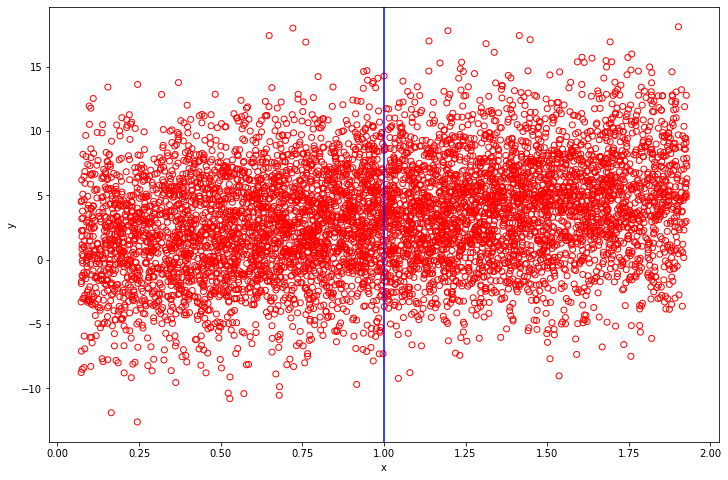

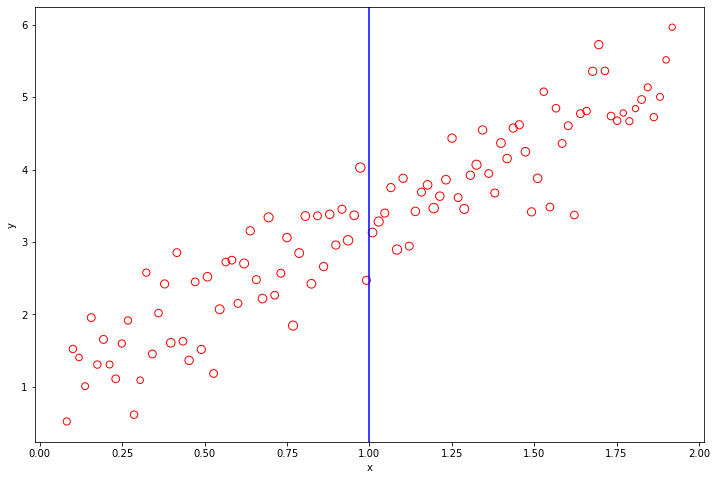

Estimation Equation:	 y ~ TREATED + x + w1 + w2
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            WLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                 2.725e+04
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:13:47   Log-Likelihood:                -9167.3
No. Observations:                6454   AIC:                         1.834e+04
Df Residuals:                    6449   BIC:                         1.838e+04
Df Model:                           4                                         
Covariance Type:                  hc1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Inte

In [5]:
# multiple covariate rdd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdd import rdd

# set the random seed:
np.random.seed(42)

# set up sampling size and cutoff, treatment varialbe:
N = 10000
x = np.random.normal(1, 1, N)
epsilon = np.random.normal(1, 1, N)
threshold = 1
treatment = np.where(x >= threshold, 1, 0)
w1 = np.random.normal(0, 1, N)
w2 = np.random.normal(0, 4, N)
y = .5 * treatment + 2 * x - .2 * w1 + 1 * w2 + epsilon

data = pd.DataFrame({'y':y, 'x': x, 'w1':w1, 'w2':w2})
data.head()


# set up bandwidth:
bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)
data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=threshold)

# scatter
plt.figure(figsize=(12, 8))
plt.scatter(data_rdd['x'], data_rdd['y'], facecolors='none', edgecolors='r')
plt.xlabel('x')
plt.ylabel('y')
plt.axvline(x=threshold, color='b')
plt.show()


#graphy

data_binned = rdd.bin_data(data_rdd, 'y', 'x', 100)

plt.figure(figsize=(12, 8))
plt.scatter(data_binned['x'], data_binned['y'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='r')
plt.axvline(x=threshold, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# estimation
model = rdd.rdd(data_rdd, 'x', 'y', cut=threshold, controls=['w1', 'w2'])
print(model.fit(cov_type='hc1').summary())

#placebo(Let's put a fake threshold at 0, and test for the causal effect there.)

data_placebo = rdd.truncated_data(data, 'x', yname='y', cut=0)
model = rdd.rdd(data_placebo, 'x', 'y', cut=0, controls=['w1'])
print(model.fit().summary())


Optimal bandwidth: 0.753070325916421


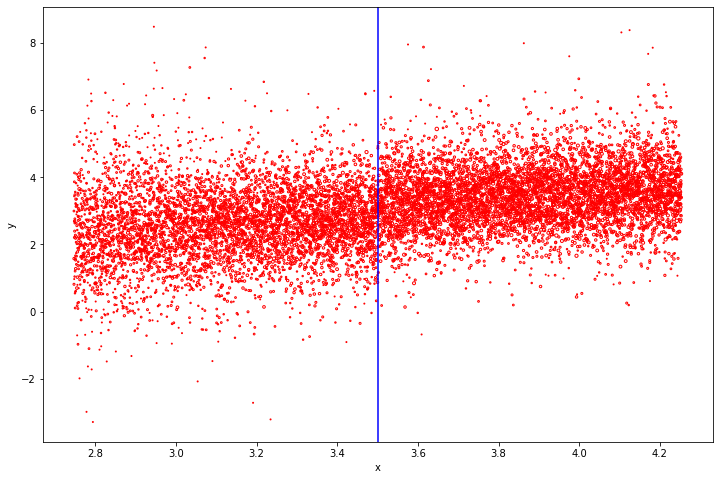

table_iv:
                  b         se       t    pval
Intercept  156.5662  2786.4844  0.0562  0.9552
treatment   35.7337   631.2014  0.0566  0.9549
x          -48.6604   880.6110 -0.0553  0.9559



In [17]:
#iv- RDD:
import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy
import scipy.stats as stats
import linearmodels.iv as iv
from rdd import rdd

# set the random seed:
np.random.seed(1234567)

# set sample size:
n = 100000

# set true parameters (betas and sd of u):
beta0 = 1
beta1 = 0.5
su = 2
d=0.5

# draw a sample of size n:
x = stats.norm.rvs(4, 1, size=n)
u = stats.norm.rvs(0, su, size=n)
z = np.random.normal(0, 1, n)
epsilon = np.random.normal(1, 1, n)

threshold = 3.5
treatment = np.where(x >= threshold, 1, 0)
# single rdd
y = d * treatment + beta0 + beta1 * x + u




data = pd.DataFrame({'y': y, 'x': x,'z':z,'treatment':treatment})


# set up bandwidth:
bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)
data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=threshold)

# scatter

data_binned = rdd.bin_data(data_rdd, 'y', 'x', 10000)

plt.figure(figsize=(12, 8))
plt.scatter(data_binned['x'], data_binned['y'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='r')
plt.axvline(x=threshold, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# estimation
reg_iv = iv.IV2SLS.from_formula(formula='y ~ 1+treatment+[x ~ z]', data=data_rdd)
results_iv = reg_iv.fit(cov_type='unadjusted',debiased=True)
table_iv=pd.DataFrame({'b':round(results_iv.params,4),
                      'se':round(results_iv.std_errors,4),
                      't':round(results_iv.tstats,4),
                      'pval':round(results_iv.pvalues,4)})

print(f'table_iv:\n{table_iv}\n')




Optimal bandwidth: 0.8137414715736015


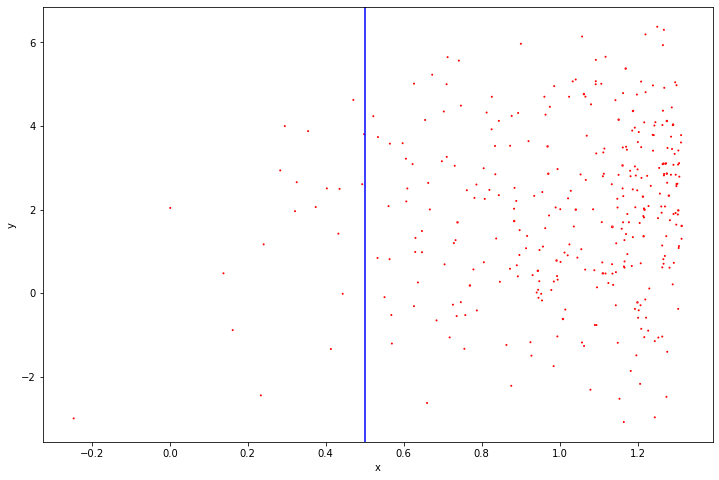

table_iv:
                b      se       t    pval
Intercept  3.3106  3.0335  1.0914  0.2758
treatment  4.8460  7.4409  0.6513  0.5153
x         -5.8094  9.8240 -0.5913  0.5547



In [16]:
#placebo(Let's put a fake threshold at 0.5, and test for the causal effect there.)

import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy
import scipy.stats as stats
import linearmodels.iv as iv
from rdd import rdd

# set the random seed:
np.random.seed(1234567)

# set sample size:
n = 100000

# set true parameters (betas and sd of u):
beta0 = 1
beta1 = 0.5
su = 2
d=0.5

# draw a sample of size n:
x = stats.norm.rvs(4, 1, size=n)
u = stats.norm.rvs(0, su, size=n)
z = np.random.normal(0, 1, n)
epsilon = np.random.normal(1, 1, n)

threshold = 0.5
treatment = np.where(x >= threshold, 1, 0)
# single rdd
y = d * treatment + beta0 + beta1 * x + u




data = pd.DataFrame({'y': y, 'x': x,'z':z,'treatment':treatment})


# set up bandwidth:
bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)
data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=threshold)

# scatter

data_binned = rdd.bin_data(data_rdd, 'y', 'x', 10000)

plt.figure(figsize=(12, 8))
plt.scatter(data_binned['x'], data_binned['y'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='r')
plt.axvline(x=threshold, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# estimation
reg_iv = iv.IV2SLS.from_formula(formula='y ~ 1+treatment+[x ~ z]', data=data_rdd)
results_iv = reg_iv.fit(cov_type='unadjusted',debiased=True)
table_iv=pd.DataFrame({'b':round(results_iv.params,4),
                      'se':round(results_iv.std_errors,4),
                      't':round(results_iv.tstats,4),
                      'pval':round(results_iv.pvalues,4)})

print(f'table_iv:\n{table_iv}\n')


Optimal bandwidth: 0.753070325916421


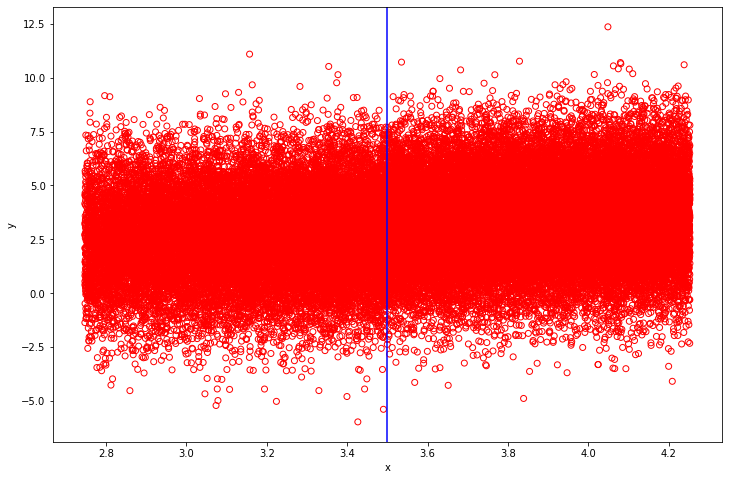

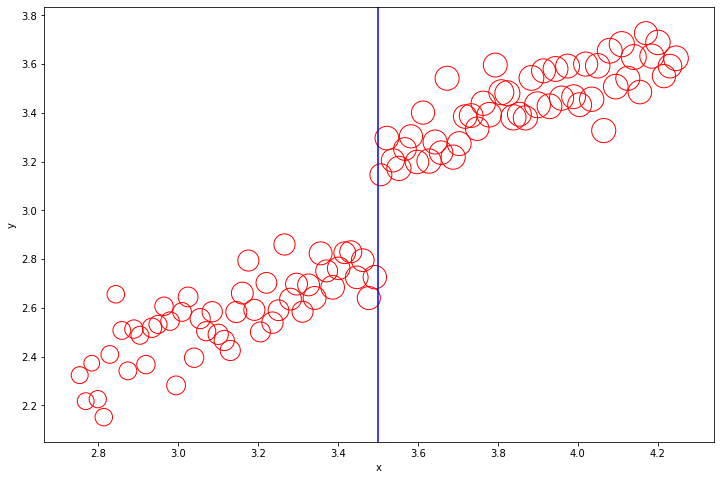

Estimation Equation:	 y ~ TREATED + x + y_lag
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            WLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     780.8
Date:                Sun, 13 Dec 2020   Prob (F-statistic):               0.00
Time:                        20:04:39   Log-Likelihood:            -1.0475e+05
No. Observations:               49466   AIC:                         2.095e+05
Df Residuals:                   49462   BIC:                         2.095e+05
Df Model:                           3                                         
Covariance Type:                  hc1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

In [45]:
#AR(1)-STCRDD:
import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy
import scipy.stats as stats

from rdd import rdd

# set the random seed:
np.random.seed(1234567)

# set sample size:
n = 100000

# set true parameters (betas and sd of u):
beta0 = 1
beta1 = 0.5
su = 2
d=0.5

# draw a sample of size n:
x = stats.norm.rvs(4, 1, size=n)
u = stats.norm.rvs(0, su, size=n)



threshold = 3.5
treatment = np.where(x >= threshold, 1, 0)
# single rdd
y = d * treatment + beta0 + beta1 * x + u

data = pd.DataFrame({'y': y, 'x': x})
data['y_lag']=data['y'].shift(1)






# set up bandwidth:
bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)
data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=threshold)

# scatter
plt.figure(figsize=(12, 8))
plt.scatter(data_rdd['x'], data_rdd['y'], facecolors='none', edgecolors='r')
plt.xlabel('x')
plt.ylabel('y')
plt.axvline(x=threshold, color='b')
plt.show()


#graphy

data_binned = rdd.bin_data(data_rdd, 'y', 'x', 100)

plt.figure(figsize=(12, 8))
plt.scatter(data_binned['x'], data_binned['y'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='r')
plt.axvline(x=threshold, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# estimation





model = rdd.rdd(data_rdd, 'x', 'y', cut=threshold, controls=['y_lag'])
print(model.fit(cov_type='hc1').summary())

#placebo(Let's put a fake threshold at 0.5, and test for the causal effect there.)

data_placebo = rdd.truncated_data(data, 'x', yname='y', cut=0.5)
model = rdd.rdd(data_placebo, 'x', 'y', cut=3, controls=['y_lag'])
print(model.fit().summary())





In [60]:
#Threshold-AR(1)-STCRDD for y_lag

import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy
import scipy.stats as stats
import linearmodels.iv as iv
from rdd import rdd

# set the random seed:
np.random.seed(1234567)

# set sample size:
n = 100000

# set true parameters (betas and sd of u):
beta0 = 1
beta1 = 0.5
su = 2
d=0.5

# draw a sample of size n:
x = stats.norm.rvs(4, 1, size=n)
u = stats.norm.rvs(0, su, size=n)
threshold = 2.5
treatment = np.where(x >= threshold, 1, 0)
z= np.random.normal(0, 1, n)
y = d * treatment + beta0 + beta1 * x + u
data = pd.DataFrame({'y': y, 'x': x,'z':z,'treatment':treatment})
data['y_lag']=data['y'].shift(1)
data['w']=treatment * data['y_lag']
data1 = pd.DataFrame({'y': y, 'x': x,'z':z,'treatment':treatment,'w':w})





# set up bandwidth:
bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['y_lag'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)
data_rdd = rdd.truncated_data(data, 'y_lag', bandwidth_opt, cut=threshold)






#basic results
model = rdd.rdd(data_rdd, 'x', 'y', cut=threshold, controls=['y_lag','w'])
print(model.fit(cov_type='hc1').summary())


# placebo

model = rdd.rdd(data_rdd, 'x', 'y', cut=0.5, controls=['y_lag','w'])
print(model.fit(cov_type='hc1').summary())

Optimal bandwidth: 1.56386443468818
Estimation Equation:	 y ~ TREATED + x + y_lag + w
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.078
Model:                            WLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     1075.
Date:                Sun, 13 Dec 2020   Prob (F-statistic):               0.00
Time:                        20:53:43   Log-Likelihood:            -1.0584e+05
No. Observations:               50080   AIC:                         2.117e+05
Df Residuals:                   50075   BIC:                         2.117e+05
Df Model:                           4                                         
Covariance Type:                  hc1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

In [61]:
#Threshold-STCRDD for y_lag

import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy
import scipy.stats as stats
import linearmodels.iv as iv
from rdd import rdd

# set the random seed:
np.random.seed(1234567)

# set sample size:
n = 100000

# set true parameters (betas and sd of u):
beta0 = 1
beta1 = 0.5
su = 2
d=0.5

# draw a sample of size n:
x = stats.norm.rvs(4, 1, size=n)
u = stats.norm.rvs(0, su, size=n)
threshold = 2.5
treatment = np.where(x >= threshold, 1, 0)
z= np.random.normal(0, 1, n)
y = d * treatment + beta0 + beta1 * x + u
data = pd.DataFrame({'y': y, 'x': x,'z':z,'treatment':treatment})
data['y_lag']=data['y'].shift(1)
data['w']=treatment * data['y_lag']
data1 = pd.DataFrame({'y': y, 'x': x,'z':z,'treatment':treatment,'w':w})





# set up bandwidth:
bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['y_lag'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)
data_rdd = rdd.truncated_data(data, 'y_lag', bandwidth_opt, cut=threshold)






#basic results
model = rdd.rdd(data_rdd, 'x', 'y', cut=threshold, controls=['w'])
print(model.fit(cov_type='hc1').summary())


# placebo

model = rdd.rdd(data_rdd, 'x', 'y', cut=0.5, controls=['w'])
print(model.fit(cov_type='hc1').summary())

Optimal bandwidth: 1.56386443468818
Estimation Equation:	 y ~ TREATED + x + w
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.078
Model:                            WLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     1433.
Date:                Sun, 13 Dec 2020   Prob (F-statistic):               0.00
Time:                        20:55:31   Log-Likelihood:            -1.0584e+05
No. Observations:               50080   AIC:                         2.117e+05
Df Residuals:                   50076   BIC:                         2.117e+05
Df Model:                           3                                         
Covariance Type:                  hc1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

In [63]:
#AR-STCRDD for y_lag

import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy
import scipy.stats as stats
import linearmodels.iv as iv
from rdd import rdd

# set the random seed:
np.random.seed(1234567)

# set sample size:
n = 100000

# set true parameters (betas and sd of u):
beta0 = 1
beta1 = 0.5
su = 2
d=0.5

# draw a sample of size n:
x = stats.norm.rvs(4, 1, size=n)
u = stats.norm.rvs(0, su, size=n)
threshold = 2.5
treatment = np.where(x >= threshold, 1, 0)
z= np.random.normal(0, 1, n)
y = d * treatment + beta0 + beta1 * x + u
data = pd.DataFrame({'y': y, 'x': x,'z':z,'treatment':treatment})
data['y_lag']=data['y'].shift(1)
data['w']=treatment * data['y_lag']
data1 = pd.DataFrame({'y': y, 'x': x,'z':z,'treatment':treatment,'w':w})





# set up bandwidth:
bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['y_lag'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)
data_rdd = rdd.truncated_data(data, 'y_lag', bandwidth_opt, cut=threshold)






#basic results
model = rdd.rdd(data_rdd, 'y_lag', 'y', cut=threshold, controls=['x'])
print(model.fit(cov_type='hc1').summary())


# placebo

model = rdd.rdd(data_rdd, 'y_lag', 'y', cut=0.5, controls=['x'])
print(model.fit(cov_type='hc1').summary())

Optimal bandwidth: 1.56386443468818
Estimation Equation:	 y ~ TREATED + y_lag + x
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.076
Model:                            WLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     1380.
Date:                Sun, 13 Dec 2020   Prob (F-statistic):               0.00
Time:                        20:58:53   Log-Likelihood:            -1.0591e+05
No. Observations:               50080   AIC:                         2.118e+05
Df Residuals:                   50076   BIC:                         2.119e+05
Df Model:                           3                                         
Covariance Type:                  hc1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

/Users/hym0509/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
